## Introduction

This example demonstrates how to do structured data classification using
[TabTransformer](https://arxiv.org/abs/2012.06678), a deep tabular data modeling
architecture for supervised and semi-supervised learning.
The TabTransformer is built upon self-attention based Transformers.
The Transformer layers transform the embeddings of categorical features
into robust contextual embeddings to achieve higher predictive accuracy.



## Setup

In [1]:
import keras
from keras import layers
from keras import ops

import math
import numpy as np
import pandas as pd
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from functools import partial

## Prepare the data

This example uses the
[United States Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/census+income)
provided by the
[UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).
The task is binary classification
to predict whether a person is likely to be making over USD 50,000 a year.

The dataset includes 48,842 instances with 14 input features: 5 numerical features and 9 categorical features.

First, let's load the dataset from the UCI Machine Learning Repository into a Pandas
DataFrame:

In [2]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)
train_data = pd.read_csv(train_data_url, header=None, names=CSV_HEADER)

test_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
)
test_data = pd.read_csv(test_data_url, header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


Remove the first record (because it is not a valid data example) and a trailing 'dot' in the class labels.

In [3]:
test_data = test_data[1:]
test_data.income_bracket = test_data.income_bracket.apply(
    lambda value: value.replace(".", "")
)

Now we store the training and test data in separate CSV files.

In [4]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

## Define dataset metadata

Here, we define the metadata of the dataset that will be useful for reading and parsing
the data into input features, and encoding the input features with respect to their types.

In [5]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "age",
    "education_num",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "workclass": sorted(list(train_data["workclass"].unique())),
    "education": sorted(list(train_data["education"].unique())),
    "marital_status": sorted(list(train_data["marital_status"].unique())),
    "occupation": sorted(list(train_data["occupation"].unique())),
    "relationship": sorted(list(train_data["relationship"].unique())),
    "race": sorted(list(train_data["race"].unique())),
    "gender": sorted(list(train_data["gender"].unique())),
    "native_country": sorted(list(train_data["native_country"].unique())),
}
# Name of the column to be used as instances weight.
WEIGHT_COLUMN_NAME = "fnlwgt"
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "income_bracket"
# A list of the labels of the target features.
TARGET_LABELS = [" <=50K", " >50K"]

## Configure the hyperparameters

The hyperparameters includes model architecture and training configurations.

In [6]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 265
NUM_EPOCHS = 15

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

## Implement data reading pipeline

We define an input function that reads and parses the file, then converts features
and labels into a[`tf.data.Dataset`](https://www.tensorflow.org/guide/datasets)
for training or evaluation.

In [7]:
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    target_index = target_label_lookup(target)
    weights = features.pop(WEIGHT_COLUMN_NAME)
    return features, target_index, weights


lookup_dict = {}
for feature_name in CATEGORICAL_FEATURE_NAMES:
    vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
    # Create a lookup to convert a string values to an integer indices.
    # Since we are not using a mask token, nor expecting any out of vocabulary
    # (oov) token, we set mask_token to None and num_oov_indices to 0.
    lookup = layers.StringLookup(
        vocabulary=vocabulary, mask_token=None, num_oov_indices=0
    )
    lookup_dict[feature_name] = lookup


def encode_categorical(batch_x, batch_y, weights):
    for feature_name in CATEGORICAL_FEATURE_NAMES:
        batch_x[feature_name] = lookup_dict[feature_name](batch_x[feature_name])

    return batch_x, batch_y, weights


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = (
        tf_data.experimental.make_csv_dataset(
            csv_file_path,
            batch_size=batch_size,
            column_names=CSV_HEADER,
            column_defaults=COLUMN_DEFAULTS,
            label_name=TARGET_FEATURE_NAME,
            num_epochs=1,
            header=False,
            na_value="?",
            shuffle=shuffle,
        )
        .map(prepare_example, num_parallel_calls=tf_data.AUTOTUNE, deterministic=False)
        .map(encode_categorical)
    )
    return dataset.cache()


## Implement a training and evaluation procedure

In [8]:

def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history


## Create model inputs

Now, define the inputs for the models as a dictionary, where the key is the feature name,
and the value is a `keras.layers.Input` tensor with the corresponding feature shape
and data type.

In [9]:

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype="float32"
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype="int32"
            )
    return inputs


## Encode features

The `encode_inputs` method returns `encoded_categorical_feature_list` and `numerical_feature_list`.
We encode the categorical features as embeddings, using a fixed `embedding_dims` for all the features,
regardless their vocabulary sizes. This is required for the Transformer model.

In [10]:

def encode_inputs(inputs, embedding_dims):
    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token, nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and num_oov_indices to 0.

            # Convert the string input values into integer indices.

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(inputs[feature_name])
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:
            # Use the numerical features as-is.
            numerical_feature = ops.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list


## Implement an MLP block

In [11]:

def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer())
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)


## Experiment 1: a baseline model

In the first experiment, we create a simple multi-layer feed-forward network.

Total model weights: 110693


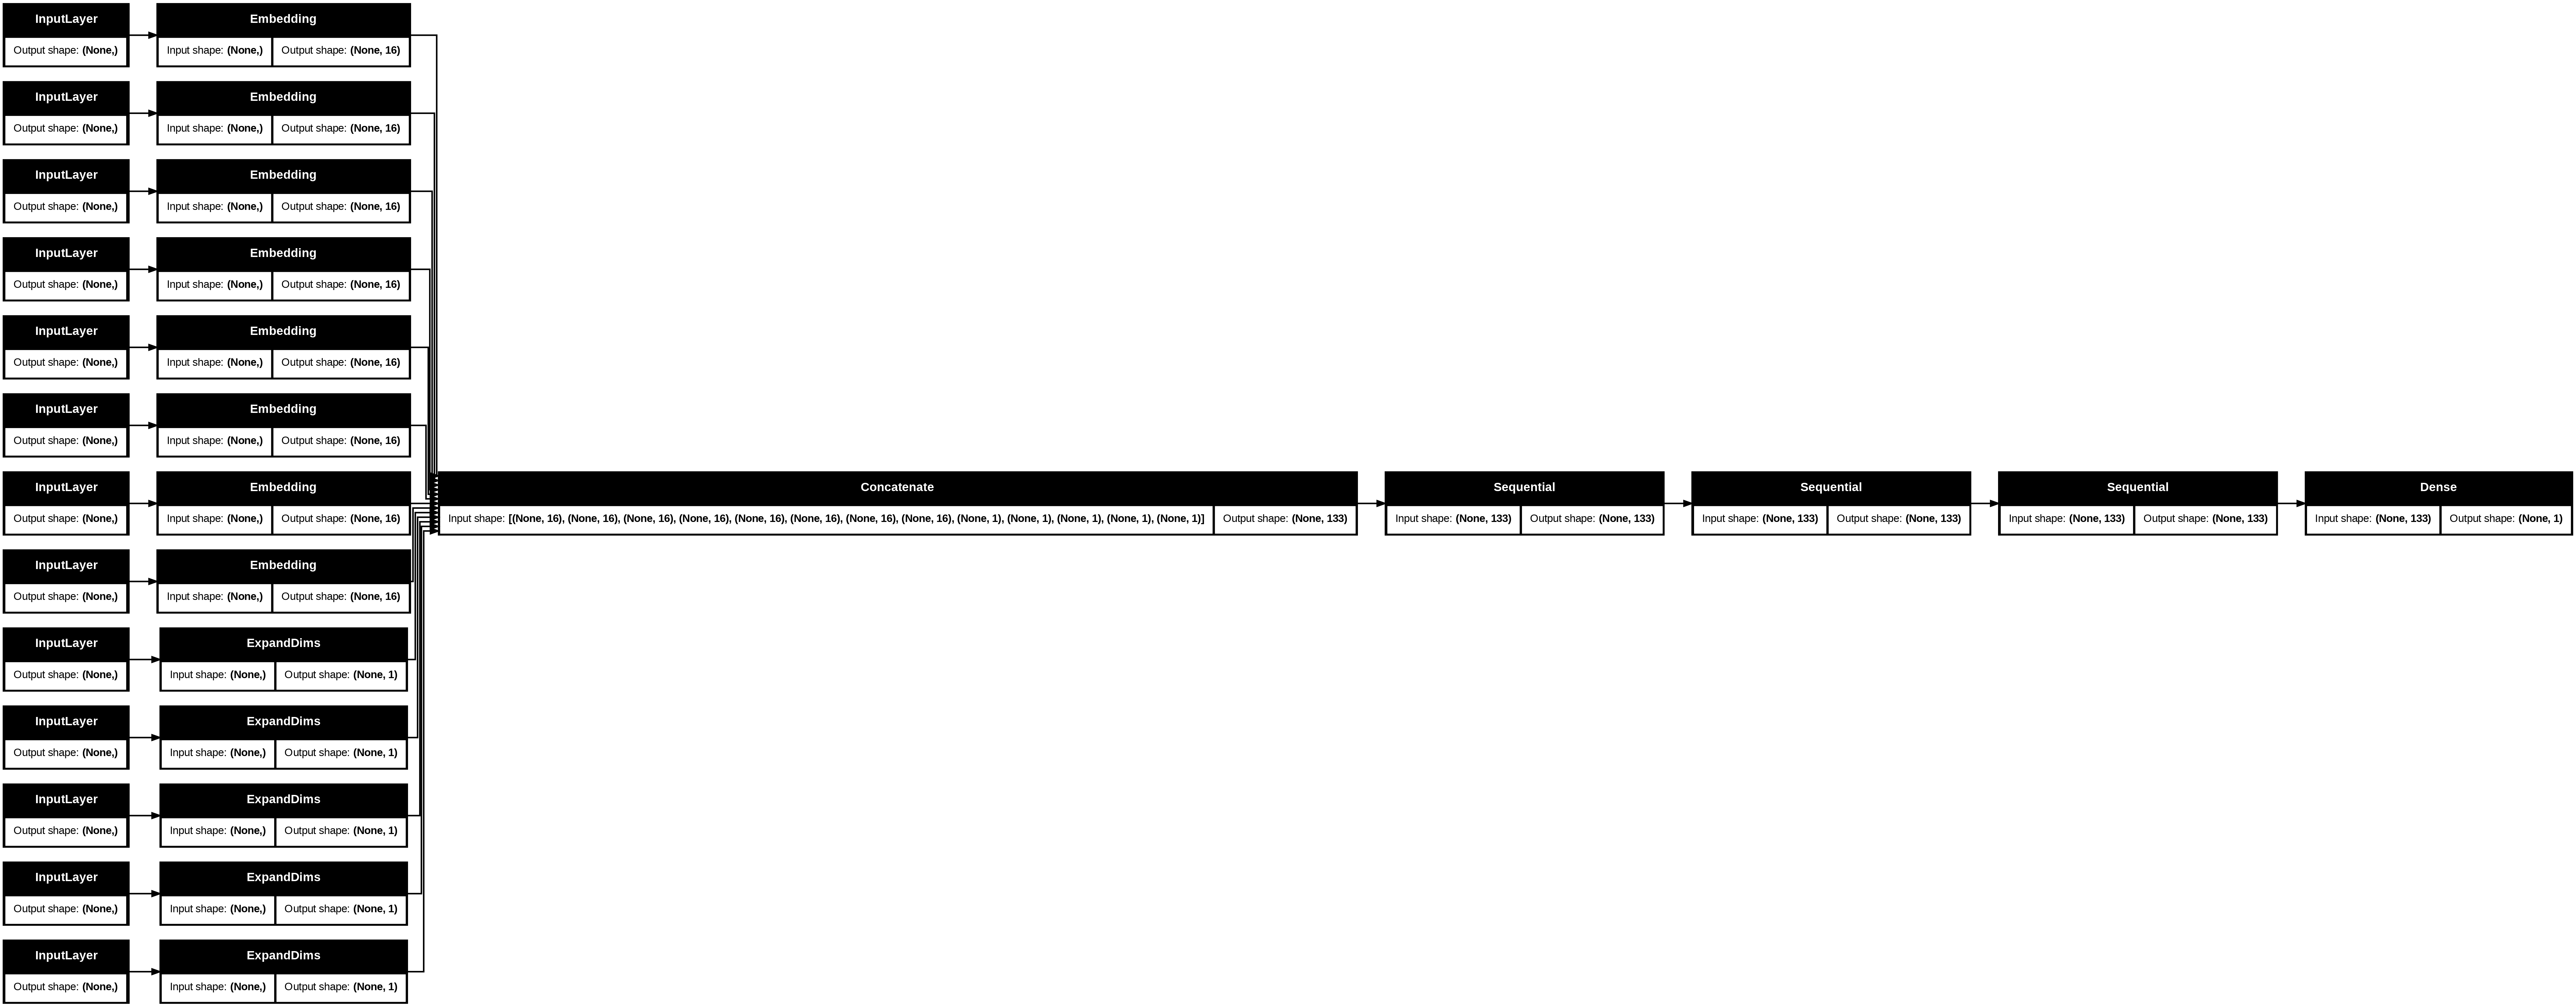

In [12]:

def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization,
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

Let's train and evaluate the baseline model:

In [13]:
history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
    123/Unknown 20s 55ms/step - accuracy: 0.6516 - loss: 127283.3750

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


123/123 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.6520 - loss: 127149.0078 - val_accuracy: 0.7058 - val_loss: 90759.0469
Epoch 2/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7464 - loss: 94544.0391 - val_accuracy: 0.8129 - val_loss: 74826.0938
Epoch 3/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7927 - loss: 81111.9297 - val_accuracy: 0.8214 - val_loss: 70535.3047
Epoch 4/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8100 - loss: 75434.8438 - val_accuracy: 0.8312 - val_loss: 65613.2812
Epoch 5/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8175 - loss: 70670.3906 - val_accuracy: 0.8267 - val_loss: 67067.3125
Epoch 6/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8219 - loss: 70547.0156 - val_accuracy: 0.8357 - val_loss: 64564.2891
Epoch 7/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8267 - loss: 68769.0234 - val_accuracy: 0.8334 - val_loss: 64504.7461
Epoch 8/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - ac

The baseline linear model achieves ~81% validation accuracy.

## Experiment 2: TabTransformer

The TabTransformer architecture works as follows:

1. All the categorical features are encoded as embeddings, using the same `embedding_dims`.
This means that each value in each categorical feature will have its own embedding vector.
2. A column embedding, one embedding vector for each categorical feature, is added (point-wise) to the categorical feature embedding.
3. The embedded categorical features are fed into a stack of Transformer blocks.
Each Transformer block consists of a multi-head self-attention layer followed by a feed-forward layer.
3. The outputs of the final Transformer layer, which are the *contextual embeddings* of the categorical features,
are concatenated with the input numerical features, and fed into a final MLP block.
4. A `softmax` classifer is applied at the end of the model.

The [paper](https://arxiv.org/abs/2012.06678) discusses both addition and concatenation of the column embedding in the
*Appendix: Experiment and Model Details* section.
The architecture of TabTransformer is shown below, as presented in the paper.

<img src="https://raw.githubusercontent.com/keras-team/keras-io/master/examples/structured_data/img/tabtransformer/tabtransformer.png" width="500"/>

In [14]:

def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = ops.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = ops.arange(start=0, stop=num_columns, step=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=partial(
                layers.LayerNormalization, epsilon=1e-6
            ),  # using partial to provide keyword arguments before initialization
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

Total model weights: 88543


Let's train and evaluate the TabTransformer model:

In [15]:
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 47s 169ms/step - accuracy: 0.7073 - loss: 111061.4062 - val_accuracy: 0.7984 - val_loss: 83721.5000
Epoch 2/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7865 - loss: 87047.9688 - val_accuracy: 0.8088 - val_loss: 78736.6719
Epoch 3/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7941 - loss: 82412.3125 - val_accuracy: 0.7988 - val_loss: 78980.0859
Epoch 4/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7957 - loss: 80707.5312 - val_accuracy: 0.8083 - val_loss: 76621.7266
Epoch 5/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8027 - loss: 78870.7578 - val_accuracy: 0.8129 - val_loss: 74272.9766
Epoch 6/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8037 - loss: 77258.6250 - val_accuracy: 0.8121 - val_loss: 74339.7578
Epoch 7/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8063 - loss: 76181.0703 - val_accuracy: 0.8157 - val_loss: 72725.1719
Epoch 8/15
123/

The TabTransformer model achieves ~85% validation accuracy.
Note that, with the default parameter configurations, both the baseline and the TabTransformer
have similar number of trainable weights: 109,629 and 92,151 respectively, and both use the same training hyperparameters.

## Conclusion

TabTransformer significantly outperforms MLP and recent
deep networks for tabular data while matching the performance of tree-based ensemble models.
TabTransformer can be learned in end-to-end supervised training using labeled examples.
For a scenario where there are a few labeled examples and a large number of unlabeled
examples, a pre-training procedure can be employed to train the Transformer layers using unlabeled data.
This is followed by fine-tuning of the pre-trained Transformer layers along with
the top MLP layer using the labeled data.
